# JAX integration

This notebook introduces the use of [JAX](https://jax.readthedocs.io) with tlm_adjoint.

JAX can be used e.g. with the Firedrake backend as an escape-hatch, allowing custom operations to be implemented using lower level code. However it can also be used independently, without a finite element code generator. Here JAX is used with tlm_adjoint to implement and differentiate a finite difference code.

## Forward problem

We consider the diffusion equation in the unit square domain, subject to homogeneous Dirichlet boundary conditions,

$$\partial_t u = \kappa \left( \partial_{xx} + \partial_{yy} \right) u + m \left( x, y \right) \qquad \text{on} ~ \left( x, y \right) \in \left( 0, 1 \right)^2,$$
$$u = 0 \qquad \text{on} ~ \partial \Omega.$$

This is discretized using a basic finite difference scheme, using second order centered finite differencing for the $x$ and $y$ dimensions and forward Euler for the $t$ dimension.

Here we implement the discretization using JAX, for $\kappa = 0.01$, $t \in \left[ 0, 0.25 \right]$, a time step size of $0.0025$, and a uniform grid with a grid spacing of $0.02$. We consider the case where $m \left( x, y \right) = 0$, and compute the $L^4$ norm of the $t = T$ solution (with the $L^4$ norm defined via nearest neighbour interpolation of the finite difference solution, ignoring boundary points where the solution is zero).

J=Array(0.11009761, dtype=float64)


Text(0.5, 1.0, '$x_{N_t}$')

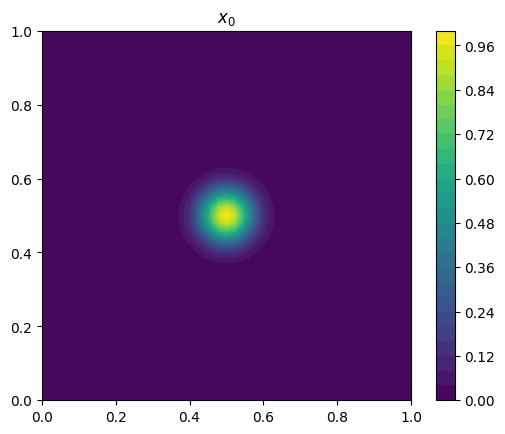

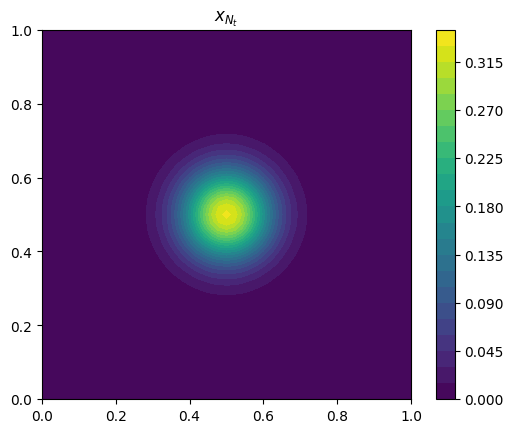

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import jax

jax.config.update("jax_enable_x64", True)

N = 50
kappa = 0.01
T = 0.25
N_t = 100

dx = 1.0 / N
dt = T / N_t
    
        
x = jax.numpy.linspace(0.0, 1.0, N + 1)
y = jax.numpy.linspace(0.0, 1.0, N + 1)
X, Y = jax.numpy.meshgrid(x, y, indexing="ij")


def timestep(x_n, m):
    x_np1 = jax.numpy.zeros_like(x_n)
    x_np1 = x_np1.at[1:-1, 1:-1].set(
        x_n[1:-1, 1:-1]
        + (kappa * dt / (dx * dx)) * (x_n[1:-1, 2:]
                                      + x_n[:-2, 1:-1]
                                      - 4.0 * x_n[1:-1, 1:-1]
                                      + x_n[2:, 1:-1]
                                      + x_n[1:-1, :-2])
        + dt * m[1:-1, 1:-1])
    return x_np1


def functional(x_n):
    x_n = x_n.reshape((N + 1, N + 1))
    return (dx * dx * (x_n[1:-1, 1:-1] ** 4).sum()) ** 0.25


def forward(x_0, m):
    x_n = x_0.copy()
    for _ in range(N_t):
        x_n = timestep(x_n, m)
    J = functional(x_n)
    return x_n, J


x_0 = jax.numpy.zeros((N + 1, N + 1), dtype=jax.numpy.double)
x_0 = x_0.at[1:-1, 1:-1].set(jax.numpy.exp(-((X[1:-1, 1:-1] - 0.5) ** 2 + (Y[1:-1, 1:-1]- 0.5) ** 2) / (2.0 * (0.05 ** 2))))
m = jax.numpy.zeros((N + 1, N + 1), dtype=jax.numpy.double)

fig, ax = plt.subplots(1, 1)
p = ax.contourf(x, y, x_0.T, 32)
fig.colorbar(p)
ax.set_aspect(1.0)
ax.set_title("$x_0$")

x_n, J = forward(x_0, m)
print(f"{J=}")

fig, ax = plt.subplots(1, 1)
p = ax.contourf(x, y, x_n.T, 32)
fig.colorbar(p)
ax.set_aspect(1.0)
ax.set_title("$x_{N_t}$")

## Adding tlm_adjoint

The tlm_adjoint `Vector` class wraps ndim 1 JAX arrays. The following uses the tlm_adjoint `call_jax` function to record JAX operations on the internal tlm_adjoint manager. Note the use of `new_block`, indicating steps, and enabling use of a step-based checkpointing schedule.

In [2]:
from tlm_adjoint import *

import jax

jax.config.update("jax_enable_x64", True)
reset_manager()

N = 50
kappa = 0.01
T = 0.25
N_t = 100

dx = 1.0 / N
dt = T / N_t
    
        
x = jax.numpy.linspace(0.0, 1.0, N + 1)
y = jax.numpy.linspace(0.0, 1.0, N + 1)
X, Y = jax.numpy.meshgrid(x, y, indexing="ij")


def timestep(x_n, m):
    x_n = x_n.reshape((N + 1, N + 1))
    m = m.reshape((N + 1, N + 1))
    x_np1 = jax.numpy.zeros_like(x_n)
    x_np1 = x_np1.at[1:-1, 1:-1].set(
        x_n[1:-1, 1:-1]
        + (kappa * dt / (dx * dx)) * (x_n[1:-1, 2:]
                                      + x_n[:-2, 1:-1]
                                      - 4.0 * x_n[1:-1, 1:-1]
                                      + x_n[2:, 1:-1]
                                      + x_n[1:-1, :-2])
        + dt * m[1:-1, 1:-1])
    return x_np1.flatten()


def functional(x_n):
    x_n = x_n.reshape((N + 1, N + 1))
    return (dx * dx * (x_n[1:-1, 1:-1] ** 4).sum()) ** 0.25


def forward(x_0, m):
    x_n = Vector((N + 1) ** 2)
    x_np1 = Vector((N + 1) ** 2)
    x_n.assign(x_0)
    for n_t in range(N_t):
        call_jax(x_np1, (x_n, m), timestep)
        x_n.assign(x_np1)
        if n_t < N_t - 1:
            new_block()
    J = new_jax_float()
    call_jax(J, x_n, functional)
    return J


x_0 = jax.numpy.zeros((N + 1, N + 1), dtype=jax.numpy.double)
x_0 = x_0.at[1:-1, 1:-1].set(jax.numpy.exp(-((X[1:-1, 1:-1] - 0.5) ** 2 + (Y[1:-1, 1:-1]- 0.5) ** 2) / (2.0 * (0.05 ** 2))))
x_0 = Vector(x_0.flatten())
m = Vector((N + 1) ** 2)

start_manager()
J = forward(x_0, m)
stop_manager()

(True, True)

We can now verify first order tangent-linear and adjoint calculations, and a second order reverse-over-forward calculation, using Taylor remainder convergence tests. Here we consider derivatives with respect to $m$.

In [3]:
min_order = taylor_test_tlm(lambda m: forward(x_0, m), m, tlm_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(lambda m: forward(x_0, m), m, adjoint_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(lambda m: forward(x_0, m), m, adjoint_order=2)
assert min_order > 1.99

Error norms, no tangent-linear   = [5.91585493e-04 2.95656972e-04 1.47794644e-04 7.38888729e-05
 3.69423255e-05]


Orders,      no tangent-linear   = [1.00066238 1.00033031 1.00016496 1.00008244]


Error norms, with tangent-linear = [5.42046248e-07 1.35247965e-07 3.37822223e-08 8.44203629e-09
 2.11008190e-09]


Orders,      with tangent-linear = [2.00280906 2.00127074 2.0006013  2.00029204]


Error norms, no adjoint   = [5.28367831e-04 2.64040997e-04 1.31984895e-04 6.59835610e-05
 3.29895606e-05]


Orders,      no adjoint   = [1.00078068 1.00038912 1.00019428 1.00009708]


Error norms, with adjoint = [5.70361189e-07 1.42261669e-07 3.55273597e-08 8.87727413e-09
 2.21875986e-09]


Orders,      with adjoint = [2.00332882 2.00154461 2.00074182 2.00036322]


Error norms, no adjoint   = [1.03746690e-04 5.17292456e-05 2.58331063e-05 1.29092469e-05
 6.45286913e-06]


Orders,      no adjoint   = [1.00401326 1.00175902 1.00081629 1.00039217]


Error norms, with adjoint = [5.28079827e-07 1.19940307e-07 2.84535988e-08 6.92060782e-09
 1.70596775e-09]


Orders,      with adjoint = [2.13843946 2.07563353 2.03964048 2.02030838]
